In [1]:
import pickle
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from tdamapper.core import MapperAlgorithm
from tdamapper.cover import CubicalCover
from tdamapper.plot import MapperLayoutInteractive, MapperLayoutStatic
from tdamapper.clustering import FailSafeClustering
from sklearn import metrics

from functions import *
from chi import *
from regressionP import *
from models import *

In [2]:
data1 = pd.read_csv("./Data/NPA_TMA2_1.csv", low_memory=False)[:-2]
data2 = pd.read_csv("./Data/NPA_TMA2_2.csv", low_memory=False)[:-2]
data3 = pd.read_csv("./Data/NPA_TMA2_3.csv", low_memory=False)[:-2]
data4 = pd.read_csv("./Data/NPA_TMA2_4.csv", low_memory=False)[:-2]
dataA2 = pd.concat([data1, data2, data3, data4], ignore_index=True)

dataA1 = pd.read_csv("./Data/NPA_TMA1.csv")[:-2]

In [66]:
def preprocess(input_data, select_lst, sample = 592):
    sample_data = input_data[input_data['當事者順位'] == 1].reset_index(drop=True, inplace=False)
    dataA = sample_data[select_lst]
    
    death_injury_data = split_death_injury(dataA['死亡受傷人數'])
    dist_df = pd.concat([dataA, death_injury_data], axis=1)
    dist_df.drop(columns=['死亡受傷人數'], inplace=True)
    
    return dist_df, sample_data

# List of columns to select
select_lst = [
    '天候名稱', 
    '路面狀況-路面狀態名稱',
    '肇因研判大類別名稱-主要', '當事者屬-性-別名稱', '當事者事故發生時年齡', 
    '車輛撞擊部位大類別名稱-最初',
    '光線名稱',
    '道路類別-第1當事者-名稱',
    '速限-第1當事者', 
    '道路型態大類別名稱',
    '事故位置大類別名稱', 
    '號誌-號誌種類名稱',
    '車道劃分設施-分向設施大類別名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
    '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱',
    '事故類型及型態大類別名稱',
    '死亡受傷人數',
    '經度', '緯度',
    '道路型態子類別名稱', '事故位置子類別名稱', '車道劃分設施-分向設施子類別名稱', '事故類型及型態子類別名稱', 
    '當事者行動狀態子類別名稱', '車輛撞擊部位子類別名稱-最初', '車輛撞擊部位子類別名稱-其他', '肇因研判子類別名稱-個別',
    
    '當事者區分-類別-大類別名稱-車種', '當事者區分-類別-子類別名稱-車種',
    '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱', '當事者行動狀態大類別名稱',
    '車輛撞擊部位大類別名稱-其他', '肇因研判大類別名稱-個別', '肇事逃逸類別名稱-是否肇逃',
    '路面狀況-路面鋪裝名稱', '路面狀況-路面缺陷名稱',
    '道路障礙-障礙物名稱', '道路障礙-視距品質名稱', '道路障礙-視距名稱','號誌-號誌動作名稱',
]

dist_dfA1 = preprocess(dataA1, select_lst, sample = 592)
dist_dfA2 = preprocess(dataA2, select_lst, sample = 11840) # 120420

    
rbind_data = pd.concat([dist_dfA1[0], dist_dfA2[0]], axis=0, ignore_index=True)

# rbind_data.loc[rbind_data['受傷'] > 1, '受傷'] = 2
# rbind_data['速限-第1當事者'] = rbind_data['速限-第1當事者'].apply(lambda x: 1 if x > 60 else 0)
# rbind_data = process_age(rbind_data)

dist_df = process_data(rbind_data)
scaler = StandardScaler()

full_dist = pd.DataFrame(scaler.fit_transform(dist_df), columns = dist_df.columns)
X1 = full_dist.drop(['受傷', '死亡'], axis=1).to_numpy()

full_dist.head()

,天候名稱,路面狀況-路面狀態名稱,肇因研判大類別名稱-主要,當事者屬-性-別名稱,當事者事故發生時年齡,車輛撞擊部位大類別名稱-最初,光線名稱,道路類別-第1當事者-名稱,速限-第1當事者,道路型態大類別名稱,...,肇因研判大類別名稱-個別,肇事逃逸類別名稱-是否肇逃,路面狀況-路面鋪裝名稱,路面狀況-路面缺陷名稱,道路障礙-障礙物名稱,道路障礙-視距品質名稱,道路障礙-視距名稱,號誌-號誌動作名稱,死亡,受傷
0,-0.447747,-0.331183,0.509425,0.739901,-1.261265,-0.372169,0.146102,2.120706,-0.531626,1.210906,...,0.508523,-0.135001,-0.045604,-0.029347,0.001515,0.118545,0.060048,0.837867,13.660843,-2.188172
1,-0.447747,-0.331183,0.509425,0.739901,0.778508,1.175119,1.465217,-0.251720,-1.391959,-0.814068,...,0.508523,-0.135001,-0.045604,-0.029347,0.001515,0.118545,0.060048,-1.192531,13.660843,-0.552999
2,1.201000,-0.331183,0.509425,0.739901,1.100577,-0.372169,-1.173013,2.911514,0.328707,1.210906,...,0.508523,-0.135001,-0.045604,-0.029347,0.001515,0.118545,0.060048,0.837867,13.660843,-2.188172
3,-0.447747,-0.331183,0.509425,0.739901,-0.563448,-0.372169,-1.173013,-0.251720,-1.391959,-0.814068,...,0.508523,-0.135001,-0.045604,-0.029347,0.001515,0.118545,0.060048,-1.192531,13.660843,-0.552999
4,1.201000,-0.331183,0.509425,0.739901,-1.046552,-0.372169,1.465217,2.120706,0.328707,1.210906,...,0.508523,-0.135001,-0.045604,-0.029347,0.001515,0.118545,0.060048,0.837867,13.660843,-2.188172


In [4]:
import pickle

with open('CalculatedData/mapper_graph1.pkl', 'rb') as f:
    mapper_graph1 = pickle.load(f)
    
mapper_plot1 = MapperLayoutInteractive(
    mapper_graph1,
    colors = dist_df[['速限-第1當事者']].to_numpy(),
    cmap = 'jet',
    # agg = np.nanmean,
    agg = most_frequent_nonan,
    dim = 3,
    iterations = 30,
    seed = 6,
    width = 800,
    height = 500)

# fig_mean1 = mapper_plot1.plot()
# fig_mean1.show(config={'scrollZoom': True})

In [11]:
x = vars(mapper_plot1._MapperLayoutInteractive__fig)['_data_objs'][1]['x']
y = vars(mapper_plot1._MapperLayoutInteractive__fig)['_data_objs'][1]['y']
z = vars(mapper_plot1._MapperLayoutInteractive__fig)['_data_objs'][1]['z']

threeDimData = pd.DataFrame({'x': x, 'y': y, 'z': z})

import re
data_tuple = vars(mapper_plot1._MapperLayoutInteractive__fig)['_data_objs'][1]['text']

data = []
for item in data_tuple:
    color = int(re.search(r'color: (-?\d+)', item).group(1))
    node = int(re.search(r'node: (\d+)', item).group(1))
    size = int(re.search(r'size: (\d+)', item).group(1))
    data.append({'color': color, 'node': node, 'size': size})
component_info = pd.DataFrame(data)

full_info = pd.concat([component_info, threeDimData], axis=1)

mp_content_origin = vars(mapper_plot1._MapperLayoutInteractive__graph)['_node']

mp_content = pd.DataFrame.from_dict(mp_content_origin, orient='index')
mp_content.reset_index(inplace=True)
mp_content.rename(columns={'index': 'node'}, inplace=True)

full_info = pd.merge(full_info, mp_content, on=['node', 'size'], how='inner')

## 分群後進行預測

In [140]:
calinski_data = get_calinski_from_db(full_info, 0.045)
labels = calinski_data[3]
db = calinski_data[2]
n_clusters_ = calinski_data[4]

unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

def matplotlib_to_plotly(cmap, alpha=1):
    """rgba"""
    return f'rgba({int(cmap[0]*200)}, {int(cmap[1]*200)}, {int(cmap[2]*200)}, {alpha})'

colors = [matplotlib_to_plotly(plt.cm.Spectral(each), alpha=0.8) for each in np.linspace(0, 1, len(unique_labels))]
# fig = go.Figure()

# for k, col in zip(unique_labels, colors):
#     if k == -1:
#         col = 'rgba(0,0,0,0)'

#     class_member_mask = labels == k

#     core_samples = full_info.iloc[:, 3:6][class_member_mask & core_samples_mask]
#     fig.add_trace(go.Scatter3d(
#         x=core_samples.iloc[:, 0],
#         y=core_samples.iloc[:, 1],
#         z=core_samples.iloc[:, 2],
#         mode='markers',
#         marker=dict(
#             size=6,
#             color=col,
#             opacity=0.8
#         ),
#         name=f'Cluster {k} Core'
#     ))

#     non_core_samples = full_info.iloc[:, 3:6][class_member_mask & ~core_samples_mask]
#     fig.add_trace(go.Scatter3d(
#         x=non_core_samples.iloc[:, 0],
#         y=non_core_samples.iloc[:, 1],
#         z=non_core_samples.iloc[:, 2],
#         mode='markers',
#         marker=dict(
#             size=6,
#             color=col,
#             opacity=0.5
#         ),
#         name=f'Cluster {k} Non-Core'
#     ))

# fig.update_layout(
#     title=f"Estimated number of clusters: {n_clusters_}",
#     margin=dict(l=0, r=0, b=0, t=0)
# )

# fig.show()

分群應該要：
1. 三個主要群體
2. 離群值
3. 重複資料點

其中離群值和重複資料點合併進行預測，總共為四個群體分別訓練

In [141]:
# 0.045 預測最好
calinski_data = get_calinski_from_db(full_info, 0.045)

label_0 = full_info[full_info['label'] == 0]
label_1 = full_info[full_info['label'] == 1]
label_2 = full_info[full_info['label'] == 2]
label_out = full_info[(full_info['label'] != 1) & (full_info['label'] != 2) & (full_info['label'] != 0)]

count_0 = get_count_dict(label_0)
count_1 = get_count_dict(label_1)
count_2 = get_count_dict(label_2)
count_out = get_count_dict(label_out)

print(full_info['label'].unique())

len(count_out)

[ 0  1  2 -1]


131

In [142]:
full_0 = rbind_data.loc[count_0.keys()]
full_1 = rbind_data.loc[count_1.keys()]
full_2 = rbind_data.loc[count_2.keys()]

# full_0['weight'] = full_0.index.map(count_0)
# full_1['weight'] = full_1.index.map(count_1)
# full_2['weight'] = full_2.index.map(count_2)

# 離群值不需要被處理
full_out = rbind_data.loc[count_out.keys()]

lst01 = list(count_0.keys() & count_1.keys())
lst02 = list(count_0.keys() & count_2.keys())
lst12 = list(count_1.keys() & count_2.keys())
lsto0 = list(count_out.keys() & count_0.keys())
lsto1 = list(count_out.keys() & count_1.keys())
lsto2 = list(count_out.keys() & count_2.keys())

# 將重複的key另外拉出進行分析，這裡drop是為了符合卡方的獨立性前提假設
full_01 = full_0.loc[lst01]
full_02 = full_0.loc[lst02]
full_12 = full_1.loc[lst12]

full_combine = pd.concat([full_01, full_02, full_12], axis=0) # full_out
full_combine = full_combine.reset_index()
full_combine = full_combine.drop_duplicates(subset='index', keep='first')
full_combine = full_combine.drop('index', axis=1)
# 去掉連接點，使分析更嚴謹
full_0 = full_0.drop(lst01, errors='ignore')
full_0 = full_0.drop(lst02, errors='ignore')
full_0 = full_0.drop(lsto0, errors='ignore')

full_1 = full_1.drop(lst01, errors='ignore')
full_1 = full_1.drop(lst12, errors='ignore')
full_1 = full_1.drop(lsto1, errors='ignore')

full_2 = full_2.drop(lst02, errors='ignore')
full_2 = full_2.drop(lst12, errors='ignore')
full_2 = full_2.drop(lsto2, errors='ignore')

print('01連接點數量', len(lst01))
print('02連接點數量', len(lst02))
print('12連接點數量', len(lst12))
print('o0連接點數量', len(lsto0))
print('o1連接點數量', len(lsto1))
print('o2連接點數量', len(lsto2))
print('離群值數量', full_out.shape[0])

full_combine.shape[0] + full_0.shape[0] + full_1.shape[0] + full_2.shape[0] == rbind_data.shape[0]

01連接點數量 220
02連接點數量 0
12連接點數量 0
o0連接點數量 18
o1連接點數量 11
o2連接點數量 15
離群值數量 131


False

## 分別做預測

In [97]:
lst_logit = [
    '路面狀況-路面狀態名稱',
    # '肇因研判大類別名稱-主要', # 降低預測值
    '當事者屬-性-別名稱', '當事者事故發生時年齡', 
    '車輛撞擊部位大類別名稱-最初',
    '光線名稱',
    '道路類別-第1當事者-名稱',
    '速限-第1當事者',
    '道路型態大類別名稱',
    '事故位置大類別名稱', 
    '號誌-號誌種類名稱',
    '車道劃分設施-分向設施大類別名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
    '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱',
    '事故類型及型態大類別名稱',
    '事故位置子類別名稱', '事故類型及型態子類別名稱', 
    '當事者行動狀態子類別名稱', '車輛撞擊部位子類別名稱-最初', '肇因研判子類別名稱-個別',
    # '當事者區分-類別-大類別名稱-車種', # 降低預測值
    '當事者區分-類別-子類別名稱-車種',
    '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱', 
    '當事者行動狀態大類別名稱',
    '車輛撞擊部位大類別名稱-其他', '肇因研判大類別名稱-個別', '肇事逃逸類別名稱-是否肇逃',
    '號誌-號誌動作名稱',
    # '路面狀況-路面鋪裝名稱', '道路障礙-視距名稱', '車道劃分設施-分向設施子類別名稱', '車道劃分設施-分道設施-快慢車道間名稱', '車輛撞擊部位大類別名稱-其他',
    # '道路障礙-障礙物名稱', '道路型態子類別名稱', '路面狀況-路面缺陷名稱', '天候名稱', '車輛撞擊部位子類別名稱-其他',
]

def get_clusterN_logit(cluster_data, lst):
    scaler = StandardScaler()
    
    c0_for_lm = process_data(cluster_data)
    c0_for_lm_X = pd.DataFrame(scaler.fit_transform(c0_for_lm), columns=c0_for_lm.columns).reset_index(drop=True, inplace=False)
    # label設定
    c0_for_lm_y = cluster_data.apply(lambda row: 1 if row['死亡'] != 0 else 2, axis=1)
        
    c0_for_lm_X = c0_for_lm_X[lst]
    
    return c0_for_lm_X, c0_for_lm_y


full_combine_X, full_combine_y = get_clusterN_logit(full_combine, lst_logit)
full_0_X, full_0_y = get_clusterN_logit(full_0, lst_logit)
full_1_X, full_1_y = get_clusterN_logit(full_1, lst_logit)
full_2_X, full_2_y = get_clusterN_logit(full_2, lst_logit)

full_out_X, full_out_y = get_clusterN_logit(full_out, lst_logit) # 新增

print(full_combine_y.value_counts())
print(full_0_y.value_counts())
print(full_1_y.value_counts())
print(full_2_y.value_counts())

2    214
1      6
dtype: int64
2    112034
1       440
dtype: int64
2    5659
1      73
dtype: int64
2    2390
1      65
dtype: int64


### 分為連接點預測、最大群預測、低速限預測、高速限預測

## logistic 加權平均準確

In [99]:
matrix_out, score_out, cm_out = logistic_cm_gridsearch(full_out_X, full_out_y)

/Users/wangqiqian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/wangqiqian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/wangqiqian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/wangqiqian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/wangqiqian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/wangqiqian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: Conver

In [100]:
cm_out

array([[1, 1],
       [0, 2]])

In [70]:
# 0.045 效果最好
start_time = time.time()
# matrix_combine, score_combine, cm_combine = logistic_cm_gridsearch(full_combine_X,  full_combine_y)
matrix_0, score_0, cm_0 = logistic_cm_gridsearch(full_0_X, full_0_y)
matrix_1, score_1, cm_1 = logistic_cm_gridsearch(full_1_X, full_1_y)
matrix_2, score_2, cm_2 = logistic_cm_gridsearch(full_2_X, full_2_y)
# print(score_combine, score_0, score_1, score_2)
print(score_0, score_1, score_2)
end_time = time.time()
elapsed_time = end_time - start_time
print(elapsed_time)

0.7522522522522522 0.8055555555555556 0.6904761904761905
143.0434651374817


In [181]:
# print(cm_combine)
# matrix_combine

In [71]:
print(cm_0)
matrix_0

[[81 30]
 [25 86]]


,Label,Precision,Recall,F1 Score
0,Class_0,0.764151,0.729730,0.746544
1,Class_1,0.741379,0.774775,0.757709


In [72]:
print(cm_1)
matrix_1

[[15  3]
 [ 4 14]]


,Label,Precision,Recall,F1 Score
0,Class_0,0.789474,0.833333,0.810811
1,Class_1,0.823529,0.777778,0.800000


In [73]:
print(cm_2)
matrix_2

[[12  9]
 [ 4 17]]


,Label,Precision,Recall,F1 Score
0,Class_0,0.750000,0.571429,0.648649
1,Class_1,0.653846,0.809524,0.723404


In [74]:
cm_0 + cm_1 + cm_2

array([[108,  42],
       [ 33, 117]])

In [75]:
de = full_0_X.shape[0] + full_1_X.shape[0] + full_2_X.shape[0]
logit_avg_score = (full_0_X.shape[0]/de)*score_0 + (full_1_X.shape[0]/de)*score_1 + (full_2_X.shape[0]/de)*score_2
print(logit_avg_score)

0.7535275135452492


In [26]:
logistic_metrics = calculate_metrics(cm_combine + cm_0 + cm_1 + cm_2)
logistic_metrics_origin = calculate_metrics(cm_origin)
data = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score"],
    "LR Mapper": logistic_metrics,
    "LR Origin": logistic_metrics_origin,
}

metrics_df = pd.DataFrame(data)
metrics_df

,Metric,LR Mapper,LR Origin
0,Accuracy,0.646587,0.632484
1,Precision,0.439261,0.423656
2,Recall,0.755901,0.706870
3,F1 Score,0.555636,0.529788


## svm 加權平均準確

In [47]:
start_time = time.time()
# svc_matrix_com, svc_score_com, svc_cm_combine = svc_cm_with_grid_search(full_combine_X, full_combine_y)
svc_matrix_0, svc_score_0, svc_cm_0 = svc_cm_with_grid_search(full_0_X, full_0_y)
svc_matrix_1, svc_score_1, svc_cm_1 = svc_cm_with_grid_search(full_1_X, full_1_y)
svc_matrix_2, svc_score_2, svc_cm_2 = svc_cm_with_grid_search(full_2_X, full_2_y)
print(svc_score_0, svc_score_1, svc_score_2)
end_time = time.time()
elapsed_time = end_time - start_time
print(elapsed_time)

/Users/wangqiqian/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/Users/wangqiqian/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/Users/wangqiqian/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/Users/wangqiqian/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/Users/wangqiqian/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/Users/wangqiqian/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning:

Liblinear failed to co

0.7432432432432432 0.8055555555555556 0.6904761904761905
1336.5325238704681


/Users/wangqiqian/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



In [48]:
de = full_0_X.shape[0] + full_1_X.shape[0] + full_2_X.shape[0]
svm_avg_score = (full_0_X.shape[0]/de)*svc_score_0 + (full_1_X.shape[0]/de)*svc_score_1 + (full_2_X.shape[0]/de)*svc_score_2
print(svm_avg_score)

0.745129777082935


# 原始資料預測

In [33]:
origin_X, origin_y = get_clusterN_logit(rbind_data, lst_logit)

In [53]:
start_time = time.time()

matrix_origin, score_origin, cm_origin = logistic_cm_gridsearch(origin_X, origin_y)
print(score_origin)

end_time = time.time()
elapsed_time = end_time - start_time
print(elapsed_time)

0.6836158192090396
107.09971189498901


In [57]:
start_time = time.time()

svc_matrix_origin, svc_score_origin, svc_cm_origin = svc_cm_with_grid_search(origin_X, origin_y)
print(svc_score_origin)

end_time = time.time()
elapsed_time = end_time - start_time
print(elapsed_time)

/Users/wangqiqian/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/Users/wangqiqian/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/Users/wangqiqian/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/Users/wangqiqian/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/Users/wangqiqian/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



0.6836158192090396
11528.745369672775


/Users/wangqiqian/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



# 比較兩個混淆矩陣

### 原始資料

In [108]:
import seaborn as sns

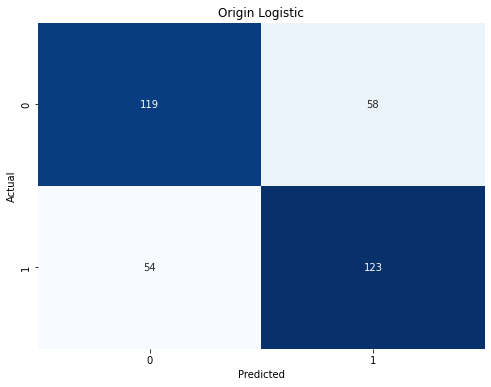

In [120]:
cm_origin

plt.figure(figsize=(8, 6))
sns.heatmap(cm_origin, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Origin Logistic')

plt.savefig('CalculatedData/confusion_heatmap/origin_logistic.png', format='png')

plt.show()

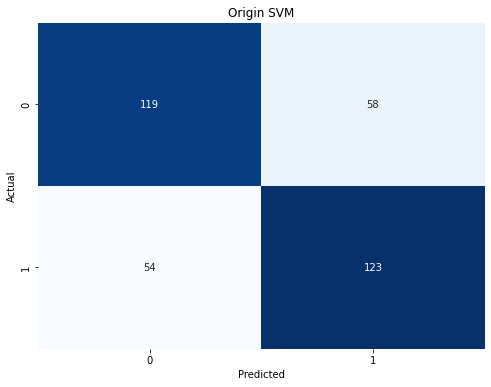

In [121]:
svc_cm_origin

plt.figure(figsize=(8, 6))
sns.heatmap(cm_origin, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Origin SVM')

plt.savefig('CalculatedData/confusion_heatmap/origin_svm.png', format='png')

plt.show()

### 分群資料

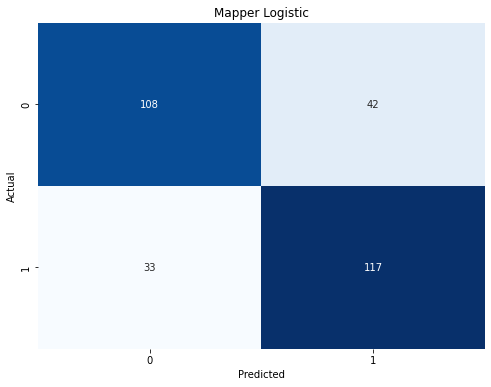

In [122]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_0 + cm_1 + cm_2, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Mapper Logistic')

plt.savefig('CalculatedData/confusion_heatmap/mapper_logistic.png', format='png')

plt.show()

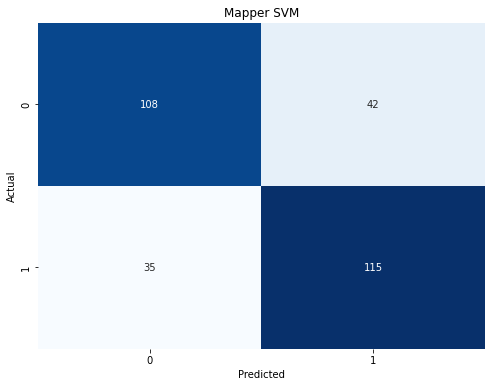

In [123]:
plt.figure(figsize=(8, 6))
sns.heatmap(svc_cm_0 + svc_cm_1 + svc_cm_2, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Mapper SVM')

plt.savefig('CalculatedData/confusion_heatmap/mapper_svm.png', format='png')

plt.show()

In [59]:
def calculate_metrics(confusion_matrix):
    TP = confusion_matrix[1, 1]
    TN = confusion_matrix[0, 0]
    FP = confusion_matrix[0, 1]
    FN = confusion_matrix[1, 0]
    
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    f1_score = 2 * (precision * recall) / (precision + recall)
    
    return accuracy, precision, recall, f1_score

In [101]:
logistic_metrics = calculate_metrics(cm_0 + cm_1 + cm_2)
svc_metrics = calculate_metrics(svc_cm_0 + svc_cm_1 + svc_cm_2)

data = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score"],
    "Logistic Regression": logistic_metrics,
    "SVC": svc_metrics
}

metrics_df = pd.DataFrame(data)
metrics_df

,Metric,Logistic Regression,SVC
0,Accuracy,0.750000,0.743333
1,Precision,0.735849,0.732484
2,Recall,0.780000,0.766667
3,F1 Score,0.757282,0.749186


In [102]:
logistic_metrics = calculate_metrics(cm_origin)
svc_metrics = calculate_metrics(svc_cm_origin)

data = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score"],
    "Logistic Regression": logistic_metrics,
    "SVC": svc_metrics
}

metrics_df = pd.DataFrame(data)
metrics_df

,Metric,Logistic Regression,SVC
0,Accuracy,0.683616,0.683616
1,Precision,0.679558,0.690058
2,Recall,0.694915,0.666667
3,F1 Score,0.687151,0.678161


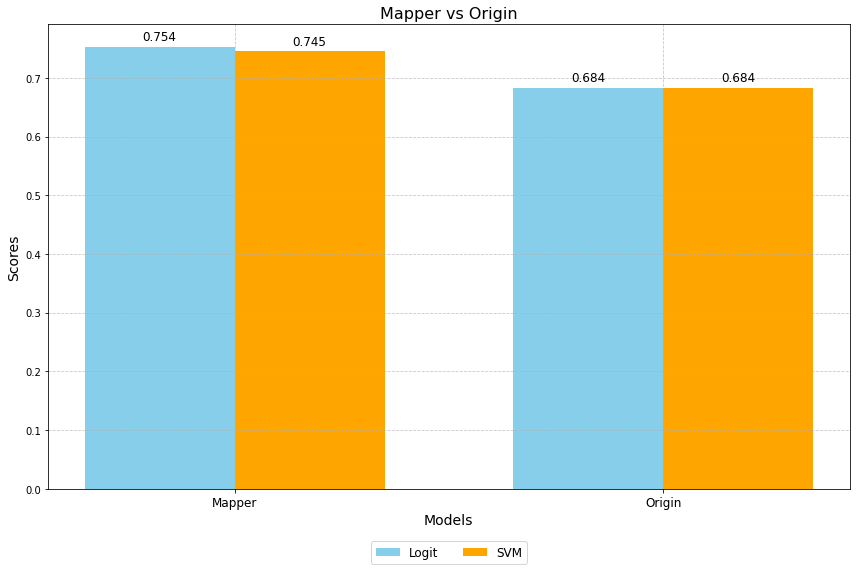

In [95]:
from matplotlib import rcParams

rcParams['font.sans-serif'] = ['DejaVu Sans']

categories = ['Mapper', 'Origin']
logit_scores = [logit_avg_score, score_origin]
svm_scores = [svm_avg_score, svc_score_origin]

x = np.arange(len(categories))
width = 0.35  

fig, ax = plt.subplots(figsize=(12, 8))  # 设置图像大小
rects1 = ax.bar(x - width/2, logit_scores, width, label='Logit', color='skyblue')
rects3 = ax.bar(x + width/2, svm_scores, width, label='SVM', color='orange')

# 添加网格线
ax.grid(True, linestyle='--', alpha=0.7)

ax.set_xlabel('Models', fontsize=14)
ax.set_ylabel('Scores', fontsize=14)
ax.set_title('Mapper vs Origin', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(categories, fontsize=12)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2, fontsize=12)

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 增加间距以避免重叠
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=12)

autolabel(rects1)
autolabel(rects3)

fig.tight_layout()

plt.show()

fig.savefig('CalculatedData/道路分析.png', bbox_inches='tight')